In [1]:
import graph_tool.all as gt
from math import sqrt

In [2]:
from random import *

In [3]:
csvGraphsPath="../graphs/csv/"
csvGraphFileName="facebook_combined.csv"
csvGraphFilePath=csvGraphsPath+csvGraphFileName
fbGraph=gt.load_graph_from_csv(csvGraphFilePath)

In [4]:
import igraph as ig

In [5]:
F=ig.Graph.Read("../graphs/ncol/facebook_combined.txt",format="ncol").as_undirected()

In [6]:
nbWorkers=31

In [7]:
import colorsys
import math
def colorDistribution(nbColors):
    assert nbColors>=1
    base=13
    maxValues=4
    nbValues=math.ceil(nbColors/base)
    if nbValues==1:
        values=[1]
    else:
        denominatorV=min(maxValues,nbValues)
        values=[min(1,0.5+0.5*v/(denominatorV-1)) for v in range(denominatorV)]

    if nbColors==1:
        hues=[0]
    else:
        denominatorH=min(base,nbColors)
        hues=[h/(denominatorH) for h in range(denominatorH)]
    sats=[1]
    nbSat=1
    if nbValues>maxValues:
        nbSat=math.ceil(nbColors/(denominatorH*denominatorV))
        sats=[min(1,0.4+0.5*s/(nbSat-1)) for s in range(nbSat)]
    HSVs=[]
    
    for value in values[::-1]:
        for i in range(len(hues)):
            for sat in sats[::-1]:
                if i%2==0:
                    HSVs.append((hues[i//2],sat,value))
                else:
                    HSVs.append((hues[-i//2],sat,value))

    colours = [colorsys.hsv_to_rgb(hue, sat, value) for hue,sat,value in HSVs]
    return colours

In [8]:
def findCommunities(graph):
    detect_communities=[graph.community_multilevel,
                        graph.community_label_propagation,
                        graph.community_leading_eigenvector]
    
    partition=detect_communities[0]()
    
    colours=colorDistribution(len(partition))

    for idx, c in enumerate(partition):
        color=colours[idx]
        for v in c:
            partition.graph.vs[v]["color"]=color
            partition.graph.vs[v]["cluster"]=idx
            for e in partition.graph.incident(v):
                ed=partition.graph.es[e]
                if ed.source in c and ed.target in c:
                    ed["color"]=[0.,0.,0.,1.]
                else:
                    ed["color"]=[0.5,0.5,0.5,1.]
    return partition

In [9]:
def chooseVertex(graph):
    assert len(graph.vs)>0, "Can't choose a vertex in an empty graph." 
    node=None
    minBetweenness = -1
    for idx, betweenness in enumerate(graph.betweenness()):
        if betweenness < minBetweenness or minBetweenness == -1 :
            node= idx
        if betweenness==0:
            break
    assert node is not None
    return node

In [10]:
def distanceCrit(value):
    outputs=[0,0,5,10]
    if value>=len(outputs):
        return outputs[-1]
    return outputs[value]

In [11]:
def maxMinPCCNodeSelection(dictPCC):
    assert dictPCC!={}
    chosenId=None
    nbNodes=len(list(dictPCC.values())[0])
    maxDist=-1
    maxSumDist=-1
    maxDistNode=None
    for nodeId in range(nbNodes):
        if nodeId not in dictPCC.keys():
            minDist=-1
            minDistNode=nodeId
            for chosenNode in dictPCC.keys():
                if minDist==-1 or dictPCC[chosenNode][nodeId]<minDist:
                    minDist=dictPCC[chosenNode][nodeId]
            #if equivalent on criterion 1, calculate criterion 2
            sumDist=-1
            if maxSumDist==-1 or minDist==maxDist:
                #sumDist=sum([dictPCC[chosenNode][nodeId] for chosenNode in dictPCC.keys()])
                #sumDist=random()
                sumDist=sum([distanceCrit(dictPCC[chosenNode][nodeId]) for chosenNode in dictPCC.keys()])
            #if better crit1 or equal crit1 but better crit2
            if minDist>maxDist or (minDist==maxDist and sumDist>maxSumDist):
                maxDist=minDist
                maxDistNode=minDistNode
                maxSumDist=sumDist
    chosenId=maxDistNode
    return chosenId

In [12]:
def maxShortestPathNodesSelection(graph,nbNodes,boundaryNodes=[]):
    assert len(graph.vs)-len(boundaryNodes)>= nbNodes, "{} {} {}".format(len(graph.vs),nbNodes,len(boundaryNodes))
    if boundaryNodes==[]:
        chosenIds=[chooseVertex(graph)]
    else:
        chosenIds=boundaryNodes.copy()
    #BFS initial des noeuds dans chosenIds
    matPCC=graph.shortest_paths_dijkstra(chosenIds)
    dictPCC={chosenId:matPCC[idxPCC] for idxPCC,chosenId in enumerate(chosenIds)}
    
    #nbNodes fois
    while len(chosenIds)-len(boundaryNodes)<nbNodes:
        chosenNodeId=maxMinPCCNodeSelection(dictPCC)

        #BFS du nouveau noeud
        dictPCC[chosenNodeId]=graph.shortest_paths_dijkstra(chosenNodeId)[0] #On prend la ligne de la matrice qui correspond au noeud
        chosenIds.append(chosenNodeId)
    assert len(chosenIds)==len(boundaryNodes)+nbNodes
    return chosenIds[len(boundaryNodes):]

In [13]:
def defineBoundary(graph, clusterVertices, clusterId):
    boundaryVertices=set()
    for v in clusterVertices: #Trouver les successeurs hors cluster aka les noeuds frontaliers au cluster
        boundaryVertices.update([bv for bv in v.successors() if bv["cluster"]!=clusterId])
    boundaryVertices=list(boundaryVertices)
    
    return boundaryVertices

In [14]:
def drawBoundedCluster(boundedCluster,workerIds,clusterId):
    for node in boundedCluster.vs:
        if node["name"]in boundedCluster.vs[workerIds]["name"]:
            node["shape"]="triangle"

    ig.plot(boundedCluster,"../graphs/img/cluster{}.png".format(clusterId))

In [15]:
def assignWorkersInCommunity(graph,clusterGraph,clusterId):
    clusterVertices=[v for v in graph.vs if v["cluster"]==clusterId]
    
    boundaryVertices=[]
    boundaryVertices=defineBoundary(graph,clusterVertices,clusterId)
    
    boundedCluster=graph.induced_subgraph(boundaryVertices+clusterVertices)
    
    #Réidentification des noeuds du graphe global vers le sous-graphe
    #clusterVertices=[boundedCluster.vs.find(v["name"]) for v in clusterVertices]
    boundaryVertices=[boundedCluster.vs.find(v["name"]) for v in boundaryVertices]
    boundaryVerticesIds=[bv.index for bv in boundaryVertices]
    
    workerIds=maxShortestPathNodesSelection(boundedCluster,clusterGraph.vs[clusterId]["nb_workers"],boundaryVerticesIds)
    
    #drawBoundedCluster(boundedCluster,workerIds,clusterId)
    
    return boundedCluster.vs[workerIds]["name"]

In [16]:
import scipy
import pylab
import scipy.cluster.hierarchy as sch
def biggestOnesSquare(srcDF):
    matPCC=srcDF.to_numpy()
    # Generate features and distance matrix.
    D = scipy.zeros([len(matPCC),len(matPCC)])
    for i in range(len(matPCC)):
        for j in range(len(matPCC)):
            D[i,j] = matPCC[i][j]

    # Compute and plot dendrogram.
    fig = pylab.figure()
    axdendro = fig.add_axes([0.09,0.1,0.2,0.8])
    Y = sch.linkage(D, method='complete')
    Z = sch.dendrogram(Y, orientation='right')
    axdendro.set_xticks([])
    axdendro.set_yticks([])

    # Plot distance matrix.
    axmatrix = fig.add_axes([0.3,0.1,0.6,0.8])
    index = Z['leaves']
    D = D[index,:]
    D = D[:,index]
    im = axmatrix.matshow(D, aspect='auto', origin='lower')
    axmatrix.set_xticks([])
    axmatrix.set_yticks([])

    # Plot colorbar.
    axcolor = fig.add_axes([0.91,0.1,0.02,0.8])
    pylab.colorbar(im, cax=axcolor)

    # Display and save figure.
    fig.show()
    fig.savefig('dendrogram.png')
    return 0


import numpy as np
import pandas as pd
from itertools import combinations  
import math 
def biggestOnesSquare(srcDF):
    maxSize=1
    maxCombination=None
    sizeLimit=int(math.sqrt(np.count_nonzero(srcDF.to_numpy()==1)))
    print(sizeLimit)
    for index, row in srcDF.iterrows():
        candidates=[srcDF.columns[idC] for idC, val in enumerate(row) if val==1]
        for i in list(range(maxSize+1,min(sizeLimit,len(candidates)))):
            for combi in combinations(candidates,i):
                candidateDF=srcDF[list(combi)].filter(items=combi, axis=0)
                #print(candidateDF)
                if (candidateDF==1).all(axis=None):
                    maxSize=len(combi)
                    maxCombination=combi
                    print(maxSize)
                    break
    return maxSize

import scipy
    import scipy.cluster.hierarchy as sch
    X=pdYLen
    #X = df.corr().values
    d = sch.distance.pdist(X)   # vector of ('55' choose 2) pairwise distances
    L = sch.linkage(d, method='complete')
    ind = sch.fcluster(L, 0.5*d.max(), 'distance')
    columns = [pdYLen.columns.tolist()[i] for i in list((np.argsort(ind)))]
    df = pdYLen[columns]
    df=df.filter(items=columns, axis=0)
    print(df)

import numpy as np
import pandas as pd

def maxNodesWithDistConstraint(matPCC, candidatesIds, minDist):
    maxCandidates=set()
    
    y=np.vectorize(lambda i:1 if i>=minDist or i==0 else 0)(np.array(matPCC)) 
    print(np.size(y))
    print(len(candidatesIds))
    nbOnes=lambda line:sum(line)
    
    lenOrderedCandidates=sorted(candidatesIds, key=lambda k:nbOnes(y[k]), reverse=True)

    pdY=pd.DataFrame(y,range(len(y[0])),range(len(y[0])))
    pdYLen=pdY[lenOrderedCandidates]
    pdYLen=pdYLen.filter(items=lenOrderedCandidates, axis=0)
    print(pdYLen)

    sizeBiggest=biggestOnesSquare(pdYLen)
    print(sizeBiggest)
    
    return maxCandidates

def subgraphCapacity(graph, minDist):
    nodes=graph.vs
    candidates=set()
    matPCC=graph.shortest_paths_dijkstra()

    for i in range(len(matPCC)):
        for j in range(len(matPCC)):
            if i!=j and matPCC[i][j]>=minDist:
                candidates.add(nodes[i])

    compatiblePositions=[idx for idx,n in enumerate(nodes) if n in candidates]
    candidates=maxNodesWithDistConstraint(matPCC, compatiblePositions, minDist)
    
    print("len(c)",len(candidates),"len(n)",len(nodes))
    return candidates

def capacityBasedWorkerAssignment(graph,partition,clusterGraph,remainingWorkers):
    assignedWorkers=remainingWorkers#0
    
    for clusterId, subgraph in enumerate(partition.subgraphs()):
        diameter=subgraph.diameter()
        radius=int(subgraph.radius())
        print("d",diameter,"r", radius)
        for eccentricity in range(2,diameter+1):
            print("e",eccentricity)
            subgraphCapacity(subgraph,eccentricity)
    assert assignedWorkers==remainingWorkers, "Only {} assigned workers out of {}".format(assignedWorkers,remainingWorkers)
    return clusterGraph

In [20]:
def sizeOrderedRoundRobinWorkerAssignement(graph,partition,clusterGraph,remainingWorkers):
    graphSize=len(graph.vs)
    relativeSizes=[len(partition.subgraph(int(cluster["name"][1:])).vs)/graphSize for cluster in clusterGraph.vs]

    sortedIdxPerSize=sorted(range(len(relativeSizes)), key=lambda k: relativeSizes[k], reverse=True)
    sortedSizes=sorted(relativeSizes)

    #Round Robin par ordre de taille des clusters
    currentCluster=0
    while remainingWorkers>0:
        currentSortedCluster=sortedIdxPerSize[currentCluster]
        if clusterGraph.vs[currentSortedCluster]["nb_workers"]<len(partition.subgraph(currentSortedCluster).vs):
            clusterGraph.vs[currentSortedCluster]["nb_workers"]+=1
            remainingWorkers-=1
        currentCluster+=1
        if currentCluster>=len(clusterGraph.vs):
            currentCluster=0
    return clusterGraph

In [21]:
def sizeProRataWorkerAssignement(graph,partition,clusterGraph,remainingWorkers):
    graphSize=len(graph.vs)
    relativeSizes=[len(partition.subgraph(int(cluster["name"][1:])).vs)/graphSize for cluster in clusterGraph.vs]

    proRataWorkers=[remainingWorkers*size for size in relativeSizes]
    intProRataWorkers=[int(prw) for prw in proRataWorkers]
    
    assignedWorkers=sum(intProRataWorkers)
    if assignedWorkers < remainingWorkers:
        remainingProRataWorkers=[prw - prw//1 for prw in proRataWorkers]
        sortedIdx=sorted(range(len(remainingProRataWorkers)), key=lambda k: remainingProRataWorkers[k], reverse=True)

        for i in range(remainingWorkers-assignedWorkers):
            intProRataWorkers[sortedIdx[i]]+=1
            assignedWorkers+=1
        
    for idx, cluster in enumerate(clusterGraph.vs):
        cluster["nb_workers"]+=intProRataWorkers[idx]
    
    assert assignedWorkers==remainingWorkers, "Only {} assigned workers out of {}".format(assignedWorkers,remainingWorkers)
    return clusterGraph

In [22]:
def diameterProRataWorkerAssignement(graph,partition,clusterGraph,remainingWorkers):

    diameters=[subgraph.diameter() for subgraph in partition.subgraphs()]
    sumDiameters=sum(diameters)
    
    proRataWorkers=[remainingWorkers*diameter/sumDiameters for diameter in diameters]
    intProRataWorkers=[int(prw) for prw in proRataWorkers]
    
    assignedWorkers=sum(intProRataWorkers)
    if assignedWorkers < remainingWorkers:
        remainingProRataWorkers=[prw - prw//1 for prw in proRataWorkers]
        sortedIdx=sorted(range(len(remainingProRataWorkers)), key=lambda k: remainingProRataWorkers[k], reverse=True)

        for i in range(remainingWorkers-assignedWorkers):
            intProRataWorkers[sortedIdx[i]]+=1
            assignedWorkers+=1
        
    for idx, cluster in enumerate(clusterGraph.vs):
        cluster["nb_workers"]+=intProRataWorkers[idx]
    
    assert assignedWorkers==remainingWorkers, "Only {} assigned workers out of {}".format(assignedWorkers,remainingWorkers)
    return clusterGraph

In [23]:
def diameterWorkerAssignment(graph,partition,clusterGraph,remainingWorkers):
    diameters=[subgraph.diameter() for subgraph in partition.subgraphs()]
    
    workers=[diameter//2+diameter%2 for diameter in diameters]
    assignedWorkers=sum(workers)
    for idx, cluster in enumerate(clusterGraph.vs):
        cluster["nb_workers"]+=workers[idx]
    
    while assignedWorkers>remainingWorkers:
        sortedIdx=sorted(range(len(workers)), key=lambda k: workers[k], reverse=True)

        for i in range(assignedWorkers-remainingWorkers):
            if clusterGraph.vs[sortedIdx[i%len(sortedIdx)]]["nb_workers"]>1:
                clusterGraph.vs[sortedIdx[i%len(sortedIdx)]]["nb_workers"]-=1
                assignedWorkers-=1
    
    if assignedWorkers<remainingWorkers:
        clusterGraph=sizeOrderedRoundRobinWorkerAssignement(graph,partition,clusterGraph,remainingWorkers-assignedWorkers)
        assignedWorkers=remainingWorkers
    
    assert assignedWorkers==remainingWorkers, "Only {} assigned workers out of {}".format(assignedWorkers,remainingWorkers)
    return clusterGraph

In [24]:
def assignWorkers(graph,nWorkers):
    assert nWorkers>=0, "{} workers to assign: Number of workers to assign must be positive or zero".format(nWorkers)
    assert len(graph.vs)>=nWorkers, "{} workers to assign on {} nodes: Can't assign more workers than there are vertices".format(nWorkers,len(graph.vs))
    partition=findCommunities(graph)
    
    clusterGraph=partition.cluster_graph("first")

    for idx, cluster in enumerate(clusterGraph.vs):
        cluster["name"]="C{}".format(idx)

    workerIds=[]
    clusterIds=[]
    if len(partition)<nWorkers:
        #Chaque cluster aura au moins un worker en lui
        for cluster in clusterGraph.vs:
            cluster["nb_workers"]=1
        
        #Attribuer le nombre de workers réel
        remainingWorkers=nWorkers-len(clusterGraph.vs)
        
        workerAssignment=[sizeProRataWorkerAssignement,
                          sizeOrderedRoundRobinWorkerAssignement,
                          diameterProRataWorkerAssignement,
                          diameterWorkerAssignment,
                          #capacityBasedWorkerAssignment,
                          #subpartitioning
                         ]
        %time clusterGraph=workerAssignment[4](graph, partition,clusterGraph, remainingWorkers)

        clusterIds=range(len(partition))
        
    elif len(partition)==nWorkers:
        #1cluster/1worker
        for cluster in clusterGraph.vs:
            cluster["nb_workers"]=1
        clusterIds=range(len(partition))
    else:
        clusterIds=maxShortestPathNodesSelection(clusterGraph,nWorkers)
        for cluster in clusterGraph.vs:
            if cluster.index in clusterIds:
                cluster["nb_workers"]=1
            else:
                cluster["nb_workers"]=0

    #Etape2
    #for chaque cluster de workers
    #prendre son sous-graphe+ les noeuds frontaliers d'autres clusters, BFS des frontières et Etape1 nb_workers fois
    for clusterId in clusterIds:
        %time workerIds.extend(assignWorkersInCommunity(graph,clusterGraph,clusterId))
    
    assert len(workerIds)==nWorkers, "Assigned {} workers instead of {}".format(len(workerIds),nWorkers)
    return workerIds,partition,clusterGraph,clusterIds

d 3 r 2
e 2
122500
350
     11   12   15   18   36   42   73   112  204  205  ...  21   247  272  \
11     1    1    1    1    1    1    1    1    1    1  ...    1    1    1   
12     1    1    1    1    1    1    1    1    1    1  ...    1    1    1   
15     1    1    1    1    1    1    1    1    1    1  ...    1    1    1   
18     1    1    1    1    1    1    1    1    1    1  ...    1    1    1   
36     1    1    1    1    1    1    1    1    1    1  ...    1    1    1   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
317    1    1    1    1    1    1    1    1    1    1  ...    0    0    0   
266    1    1    1    1    1    1    1    1    1    1  ...    0    0    0   
66     1    1    1    1    1    1    1    1    1    1  ...    0    0    0   
55     1    1    1    1    1    1    1    1    1    1  ...    0    0    0   
0      0    0    0    0    0    0    0    0    0    0  ...    0    0    0   

     26   25   317  266  66   55   0    
11     1   

<ipython-input-16-e3660aee5ea4>:7: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  D = scipy.zeros([len(matPCC),len(matPCC)])


0
len(c) 0 len(n) 350
e 3
122500
347
     343  348  349  344  345  346  347  1    2    3    ...  339  340  341  \
343    1    1    1    0    0    0    0    1    1    1  ...    1    1    1   
348    1    1    0    0    0    0    0    1    1    1  ...    1    1    1   
349    1    0    1    0    0    0    0    1    1    1  ...    1    1    1   
344    0    0    0    1    0    0    0    1    1    1  ...    1    1    1   
345    0    0    0    0    1    0    0    1    1    1  ...    1    1    1   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
63     1    0    0    0    0    0    0    0    0    0  ...    0    0    0   
117    1    0    0    0    0    0    0    0    0    0  ...    0    0    0   
147    1    0    0    0    0    0    0    0    0    0  ...    0    0    0   
185    1    0    0    0    0    0    0    0    0    0  ...    0    0    0   
212    1    0    0    0    0    0    0    0    0    0  ...    0    0    0   

     342  264  63   117  147  185  212

<ipython-input-16-e3660aee5ea4>:7: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  D = scipy.zeros([len(matPCC),len(matPCC)])


0
len(c) 0 len(n) 350
d 5 r 3
e 2
185761
431
     80   162  239  332  381  387  390  391  394  402  ...  8    6    209  \
80     1    1    1    1    1    1    1    1    1    1  ...    1    1    1   
162    1    1    1    1    1    1    1    1    1    1  ...    1    1    1   
239    1    1    1    1    1    1    1    1    1    1  ...    1    1    1   
332    1    1    1    1    1    1    1    1    1    1  ...    1    1    1   
381    1    1    1    1    1    1    1    1    1    1  ...    1    1    1   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
11     1    1    1    1    1    1    1    1    1    1  ...    0    0    1   
9      1    1    1    1    1    1    1    1    1    1  ...    0    0    0   
4      1    1    1    1    0    0    0    0    0    0  ...    1    1    0   
12     1    1    1    1    1    1    1    1    1    1  ...    0    0    0   
3      1    0    0    0    1    1    1    1    1    1  ...    0    0    0   

     14   5    11   9    4    

<ipython-input-16-e3660aee5ea4>:7: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  D = scipy.zeros([len(matPCC),len(matPCC)])


0
len(c) 0 len(n) 431
e 3
185761
431
     28   108  127  61   80   118  133  72   81   52   ...  190  229  287  \
28     1    0    0    1    1    1    1    1    1    1  ...    1    1    1   
108    0    1    0    1    1    1    1    1    1    1  ...    1    1    1   
127    0    0    1    1    1    1    1    1    1    1  ...    1    1    1   
61     1    1    1    1    1    1    1    1    1    1  ...    1    1    1   
80     1    1    1    1    1    1    1    1    1    1  ...    1    1    1   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
9      1    1    1    1    1    1    1    1    1    1  ...    0    0    0   
11     1    1    1    1    1    1    1    1    1    1  ...    0    0    0   
5      1    1    1    1    1    1    1    1    1    1  ...    0    0    0   
7      1    1    1    1    1    1    1    1    1    1  ...    0    0    0   
12     1    1    1    1    0    1    1    1    1    1  ...    0    0    0   

     299  18   9    11   5    7    12 

<ipython-input-16-e3660aee5ea4>:7: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  D = scipy.zeros([len(matPCC),len(matPCC)])


0
len(c) 0 len(n) 431
e 4
185761
372
     61   72   81   118  133  52   80   28   108  127  ...  74   82   85   \
61     1    0    0    0    0    0    1    1    1    1  ...    1    1    1   
72     0    1    0    0    0    0    1    1    1    1  ...    0    0    0   
81     0    0    1    0    0    0    1    1    1    1  ...    0    0    0   
118    0    0    0    1    0    0    1    1    1    1  ...    0    0    0   
133    0    0    0    0    1    0    1    1    1    1  ...    0    0    0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
103    1    0    0    0    0    0    0    0    0    0  ...    0    0    0   
110    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
111    0    1    0    0    0    0    0    0    0    0  ...    0    0    0   
124    1    0    0    0    0    0    0    0    0    0  ...    0    0    0   
137    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   

     93   97   103  110  111  124  137

<ipython-input-16-e3660aee5ea4>:7: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  D = scipy.zeros([len(matPCC),len(matPCC)])


0
len(c) 0 len(n) 431
e 5
185761
160
     61   72   81   118  133  28   108  127  430  358  ...  1    52   98   \
61     1    0    0    0    0    1    1    1    1    1  ...    1    0    0   
72     0    1    0    0    0    1    1    1    1    1  ...    0    0    0   
81     0    0    1    0    0    1    1    1    1    1  ...    0    0    0   
118    0    0    0    1    0    1    1    1    1    1  ...    0    0    0   
133    0    0    0    0    1    1    1    1    1    1  ...    0    0    0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
221    1    0    0    0    0    0    0    0    0    0  ...    0    0    0   
365    1    0    0    0    0    0    0    0    0    0  ...    0    0    0   
366    1    0    0    0    0    0    0    0    0    0  ...    0    0    0   
367    1    0    0    0    0    0    0    0    0    0  ...    0    0    0   
368    1    0    0    0    0    0    0    0    0    0  ...    0    0    0   

     158  210  221  365  366  367  368

<ipython-input-16-e3660aee5ea4>:7: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  D = scipy.zeros([len(matPCC),len(matPCC)])


0
len(c) 0 len(n) 431
d 2 r 1
e 2
189225
434
     6    8    80   88   98   130  202  236  281  289  ...  397  293  366  \
6      1    1    1    1    1    1    1    1    1    1  ...    1    1    1   
8      1    1    1    1    1    1    1    1    1    1  ...    1    1    1   
80     1    1    1    1    1    1    1    1    1    1  ...    1    1    1   
88     1    1    1    1    1    1    1    1    1    1  ...    1    1    1   
98     1    1    1    1    1    1    1    1    1    1  ...    1    1    1   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
352    1    1    1    1    1    1    1    1    1    1  ...    0    0    0   
190    1    1    1    1    1    1    1    1    1    1  ...    0    0    0   
327    1    1    1    1    1    1    1    1    1    1  ...    0    0    0   
383    1    1    1    1    1    1    1    1    1    1  ...    0    0    0   
426    1    1    1    1    1    1    1    1    1    1  ...    0    0    0   

     125  221  352  190  327  

<ipython-input-16-e3660aee5ea4>:7: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  D = scipy.zeros([len(matPCC),len(matPCC)])


0
len(c) 0 len(n) 435
d 2 r 1
e 2
178929
422
     219  260  293  363  364  398  406  331  390  251  ...  46   47   107  \
219    1    1    1    1    1    1    1    1    1    1  ...    1    1    1   
260    1    1    1    1    1    1    1    1    1    1  ...    1    1    1   
293    1    1    1    1    1    1    1    1    1    1  ...    1    1    1   
363    1    1    1    1    1    1    1    1    1    1  ...    1    1    1   
364    1    1    1    1    1    1    1    1    1    1  ...    1    1    1   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
19     1    1    1    1    1    1    1    1    1    1  ...    0    0    0   
35     1    1    1    1    1    1    1    1    1    1  ...    0    0    0   
21     1    1    1    1    1    1    1    1    1    1  ...    0    0    0   
53     1    1    1    1    1    1    1    1    1    1  ...    0    0    0   
88     1    1    1    1    1    1    1    1    1    1  ...    0    0    0   

     15   76   19   35   21   

<ipython-input-16-e3660aee5ea4>:7: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  D = scipy.zeros([len(matPCC),len(matPCC)])


0
len(c) 0 len(n) 423
d 4 r 2
e 2
294849
543
     197  284  308  378  411  5    163  208  271  341  ...  335  445  542  \
197    1    1    1    1    1    1    1    1    1    1  ...    1    1    1   
284    1    1    1    1    1    1    1    1    1    1  ...    1    1    1   
308    1    1    1    1    1    1    1    1    1    1  ...    1    1    1   
378    1    1    1    1    1    1    1    1    1    1  ...    1    1    1   
411    1    1    1    1    1    1    1    1    1    1  ...    1    1    1   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
140    1    1    1    1    1    1    1    1    1    1  ...    0    0    1   
315    1    1    1    1    1    1    1    1    1    1  ...    0    0    0   
451    1    1    1    1    1    1    1    1    1    1  ...    0    0    0   
81     1    1    1    1    1    1    1    1    1    1  ...    0    0    0   
0      0    0    0    0    0    1    0    0    0    0  ...    0    0    0   

     466  521  140  315  451  

<ipython-input-16-e3660aee5ea4>:7: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  D = scipy.zeros([len(matPCC),len(matPCC)])


0
len(c) 0 len(n) 543
e 3
294849
540
    19  3   5   6   8   2   16  9   7   1   ...  69  70  71  72  73  74  75  \
19   1   0   0   0   0   0   0   0   0   1  ...   1   1   1   1   1   1   1   
3    0   1   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   0   0   
5    0   0   1   0   0   0   0   0   0   1  ...   0   0   0   0   0   0   0   
6    0   0   0   1   0   0   0   0   0   1  ...   0   0   0   0   0   0   0   
8    0   0   0   0   1   0   0   0   0   1  ...   0   0   0   0   0   0   0   
..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..  ..   
74   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   1   0   
75   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   1   
76   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
77   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
78   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   

    76  77  78

<ipython-input-16-e3660aee5ea4>:7: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  D = scipy.zeros([len(matPCC),len(matPCC)])


0
len(c) 0 len(n) 543
e 4
294849
488
     19   1    24   28   35   37   39   40   41   42   ...  533  534  535  \
19     1    1    1    1    1    1    1    1    1    1  ...    1    1    1   
1      1    1    0    0    0    0    0    0    0    0  ...    0    0    0   
24     1    0    1    0    0    0    0    0    0    0  ...    0    0    0   
28     1    0    0    1    0    0    0    0    0    0  ...    0    0    0   
35     1    0    0    0    1    0    0    0    0    0  ...    0    0    0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
538    1    0    0    0    0    0    0    0    0    0  ...    0    0    0   
539    1    0    0    0    0    0    0    0    0    0  ...    0    0    0   
540    1    0    0    0    0    0    0    0    0    0  ...    0    0    0   
541    1    0    0    0    0    0    0    0    0    0  ...    0    0    0   
542    1    0    0    0    0    0    0    0    0    0  ...    0    0    0   

     536  537  538  539  540  541  542

<ipython-input-16-e3660aee5ea4>:7: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  D = scipy.zeros([len(matPCC),len(matPCC)])


0
len(c) 0 len(n) 543
d 5 r 3
e 2
104329
323
     60   98   115  257  279  163  213  18   88   130  ...  157  227  193  \
60     1    1    1    1    1    1    1    1    1    1  ...    1    1    1   
98     1    1    1    1    1    1    1    1    1    1  ...    1    1    1   
115    1    1    1    1    1    1    1    1    1    1  ...    1    1    1   
257    1    1    1    1    1    1    1    1    1    1  ...    1    1    1   
279    1    1    1    1    1    1    1    1    1    1  ...    1    1    1   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
74     1    1    1    1    1    1    1    1    1    1  ...    0    0    1   
7      1    1    1    1    1    1    1    1    1    1  ...    1    1    1   
285    1    1    1    1    1    1    1    1    1    1  ...    0    0    0   
134    1    1    1    1    1    1    1    1    1    1  ...    0    0    0   
2      1    1    1    1    1    1    1    1    1    1  ...    0    0    0   

     116  104  74   7    285  

<ipython-input-16-e3660aee5ea4>:7: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  D = scipy.zeros([len(matPCC),len(matPCC)])


0
len(c) 0 len(n) 323
e 3
104329
323
     60   198  115  281  130  213  161  257  32   163  ...  289  197  93   \
60     1    1    1    1    1    1    1    1    1    1  ...    1    1    1   
198    1    1    1    0    1    1    1    1    0    1  ...    1    1    1   
115    1    1    1    1    1    1    1    1    1    1  ...    1    1    1   
281    1    0    1    1    1    1    1    1    0    1  ...    1    0    1   
130    1    1    1    1    1    1    1    1    1    1  ...    1    1    0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
108    1    1    1    1    1    0    1    1    1    1  ...    0    0    0   
221    1    1    1    1    1    0    1    1    1    1  ...    0    0    0   
92     1    1    1    1    1    1    1    0    0    1  ...    0    0    0   
285    0    1    1    1    0    1    0    1    1    0  ...    0    0    0   
7      0    1    0    1    0    0    0    0    1    0  ...    0    0    0   

     166  121  108  221  92   285  7  

<ipython-input-16-e3660aee5ea4>:7: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  D = scipy.zeros([len(matPCC),len(matPCC)])


0
len(c) 0 len(n) 323
e 4
104329
267
     198  281  32   60   257  33   279  115  161  163  ...  229  234  254  \
198    1    0    0    1    1    0    1    1    1    1  ...    1    0    1   
281    0    1    0    1    0    0    1    1    1    1  ...    0    0    0   
32     0    0    1    1    0    0    1    1    0    0  ...    0    0    0   
60     1    1    1    1    1    1    1    1    0    0  ...    0    0    0   
257    1    0    0    1    1    0    1    1    0    0  ...    0    0    0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
268    1    0    0    0    0    0    0    0    0    0  ...    0    0    0   
272    1    0    0    0    0    0    0    0    0    0  ...    0    0    0   
283    0    0    0    0    0    0    1    0    0    0  ...    0    0    0   
287    1    0    0    0    0    0    0    0    0    0  ...    0    0    0   
296    0    0    0    1    0    0    0    0    0    0  ...    0    0    0   

     259  263  268  272  283  287  296

<ipython-input-16-e3660aee5ea4>:7: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  D = scipy.zeros([len(matPCC),len(matPCC)])


0
len(c) 0 len(n) 323
e 5
104329
17
     198  281  32   115  179  279  18   4    89   98   102  177  182  188  \
198    1    0    0    1    1    1    1    1    1    1    1    1    1    1   
281    0    1    0    1    1    1    1    0    0    0    0    0    0    0   
32     0    0    1    1    1    1    0    0    0    0    0    0    0    0   
115    1    1    1    1    0    0    0    0    0    0    0    0    0    0   
179    1    1    1    0    1    0    0    0    0    0    0    0    0    0   
279    1    1    1    0    0    1    0    0    0    0    0    0    0    0   
18     1    1    0    0    0    0    1    0    0    0    0    0    0    0   
4      1    0    0    0    0    0    0    1    0    0    0    0    0    0   
89     1    0    0    0    0    0    0    0    1    0    0    0    0    0   
98     1    0    0    0    0    0    0    0    0    1    0    0    0    0   
102    1    0    0    0    0    0    0    0    0    0    1    0    0    0   
177    1    0    0    0    0    0    0  

<ipython-input-16-e3660aee5ea4>:7: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  D = scipy.zeros([len(matPCC),len(matPCC)])
<ipython-input-16-e3660aee5ea4>:7: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  D = scipy.zeros([len(matPCC),len(matPCC)])


0
len(c) 0 len(n) 121
e 3
14641
121
     104  57   64   96   89   48   49   19   24   46   ...  114  68   81   \
104    1    1    1    0    1    1    1    1    1    0  ...    1    1    1   
57     1    1    0    0    1    1    1    1    1    0  ...    1    1    1   
64     1    0    1    0    1    1    1    1    1    0  ...    1    1    1   
96     0    0    0    1    1    1    1    1    1    0  ...    1    1    1   
89     1    1    1    1    1    1    1    1    0    1  ...    1    0    1   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
45     1    1    1    1    1    1    1    1    1    1  ...    0    0    0   
58     1    1    1    1    1    1    1    1    1    0  ...    0    1    0   
71     1    1    1    1    1    1    1    1    1    1  ...    0    0    0   
106    1    1    1    1    1    1    1    1    1    1  ...    0    0    0   
87     1    1    1    1    1    1    1    1    1    1  ...    0    0    0   

     86   105  45   58   71   106  87  

<ipython-input-16-e3660aee5ea4>:7: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  D = scipy.zeros([len(matPCC),len(matPCC)])


0
len(c) 0 len(n) 121
e 4
14641
121
     104  48   57   64   96   49   24   19   89   78   ...  114  3    51   \
104    1    1    0    0    0    1    1    1    1    1  ...    1    1    1   
48     1    1    1    1    1    0    1    0    1    1  ...    1    1    1   
57     0    1    1    0    0    1    1    1    1    1  ...    1    0    0   
64     0    1    0    1    0    1    1    1    1    1  ...    1    0    0   
96     0    1    0    0    1    1    1    1    1    1  ...    1    0    0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
106    1    1    1    1    1    1    1    1    0    0  ...    0    0    0   
22     1    0    1    1    1    0    1    0    0    0  ...    0    0    0   
44     1    1    1    1    1    1    0    0    0    0  ...    0    0    0   
58     1    1    0    0    0    0    1    0    1    1  ...    0    0    0   
87     1    1    1    1    1    0    0    0    1    0  ...    0    0    0   

     81   86   106  22   44   58   87  

<ipython-input-16-e3660aee5ea4>:7: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  D = scipy.zeros([len(matPCC),len(matPCC)])


0
len(c) 0 len(n) 121
e 5
14641
120
     104  48   100  49   89   19   57   64   96   24   ...  86   105  106  \
104    1    1    1    1    1    1    0    0    0    1  ...    0    1    1   
48     1    1    1    0    0    0    1    1    1    1  ...    1    1    1   
100    1    1    1    1    1    1    1    1    1    1  ...    0    0    0   
49     1    0    1    1    0    0    1    1    1    1  ...    0    0    0   
89     1    0    1    0    1    0    1    1    1    0  ...    1    0    0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
116    1    0    1    0    0    0    0    0    0    0  ...    0    0    0   
22     1    0    0    0    0    0    0    0    0    0  ...    0    0    0   
37     0    0    1    0    0    0    0    0    0    0  ...    0    0    0   
44     1    0    0    0    0    0    0    0    0    0  ...    0    0    0   
87     1    0    0    0    0    0    0    0    0    0  ...    0    0    0   

     110  114  116  22   37   44   87  

<ipython-input-16-e3660aee5ea4>:7: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  D = scipy.zeros([len(matPCC),len(matPCC)])


0
len(c) 0 len(n) 121
e 6
14641
62
     48   104  89   100  19   49   5    18   25   57   ...  63   67   72   \
48     1    1    0    1    0    0    1    1    1    1  ...    0    1    1   
104    1    1    1    1    1    1    1    1    1    0  ...    1    0    0   
89     0    1    1    1    0    0    1    1    1    0  ...    0    0    0   
100    1    1    1    1    1    1    0    0    0    0  ...    0    0    0   
19     0    1    0    1    1    0    0    0    0    1  ...    0    0    0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
84     1    0    0    0    0    0    0    0    0    0  ...    0    0    0   
91     1    0    0    0    0    0    0    0    0    0  ...    0    0    0   
103    0    1    0    0    0    0    0    0    0    0  ...    0    0    0   
107    0    1    0    0    0    0    0    0    0    0  ...    0    0    0   
119    0    0    0    1    0    0    0    0    0    0  ...    0    0    0   

     77   82   84   91   103  107  119  

<ipython-input-16-e3660aee5ea4>:7: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  D = scipy.zeros([len(matPCC),len(matPCC)])


0
len(c) 0 len(n) 121
e 7
14641
9
     48   104  100  19   49   57   64   89   96 
48     1    1    1    0    0    1    1    0    1
104    1    1    0    1    1    0    0    0    0
100    1    0    1    0    0    0    0    1    0
19     0    1    0    1    0    0    0    0    0
49     0    1    0    0    1    0    0    0    0
57     1    0    0    0    0    1    0    0    0
64     1    0    0    0    0    0    1    0    0
89     0    0    1    0    0    0    0    1    0
96     1    0    0    0    0    0    0    0    1
0
len(c) 0 len(n) 121
e 8
14641
2
     48   104
48     1    1
104    1    1


<ipython-input-16-e3660aee5ea4>:7: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  D = scipy.zeros([len(matPCC),len(matPCC)])
<ipython-input-16-e3660aee5ea4>:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = pylab.figure()
<ipython-input-16-e3660aee5ea4>:7: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  D = scipy.zeros([len(matPCC),len(matPCC)])
/usr/lib/python3.9/site-packages/scipy/cluster/hierarchy.py:2872: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set_xlim([0, dvw])


0
len(c) 0 len(n) 121
d 3 r 2
e 2
300304
548
     59   61   167  240  294  312  330  376  398  429  ...  40   415  23   \
59     1    1    1    1    1    1    1    1    1    1  ...    1    1    1   
61     1    1    1    1    1    1    1    1    1    1  ...    1    1    1   
167    1    1    1    1    1    1    1    1    1    1  ...    1    1    1   
240    1    1    1    1    1    1    1    1    1    1  ...    1    1    1   
294    1    1    1    1    1    1    1    1    1    1  ...    1    1    1   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
145    1    1    1    1    1    1    1    1    1    1  ...    0    0    0   
510    1    1    1    1    1    1    1    1    1    1  ...    0    0    0   
190    1    1    1    1    1    1    1    1    1    1  ...    0    0    0   
41     1    1    1    1    1    1    1    1    1    1  ...    0    1    0   
1      0    0    0    0    0    0    0    0    0    0  ...    0    0    0   

     25   198  145  510  190  

<ipython-input-16-e3660aee5ea4>:7: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  D = scipy.zeros([len(matPCC),len(matPCC)])


0
len(c) 0 len(n) 548
e 3
300304
525
     9    10   2    3    4    5    6    30   31   32   ...  538  539  540  \
9      1    0    1    1    1    1    1    1    1    1  ...    1    1    1   
10     0    1    1    1    1    1    1    1    1    1  ...    1    1    1   
2      1    1    1    0    0    0    0    0    0    0  ...    0    0    0   
3      1    1    0    1    0    0    0    0    0    0  ...    0    0    0   
4      1    1    0    0    1    0    0    0    0    0  ...    0    0    0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
543    1    1    0    0    0    0    0    0    0    0  ...    0    0    0   
544    1    1    0    0    0    0    0    0    0    0  ...    0    0    0   
545    1    1    0    0    0    0    0    0    0    0  ...    0    0    0   
546    1    1    0    0    0    0    0    0    0    0  ...    0    0    0   
547    1    1    0    0    0    0    0    0    0    0  ...    0    0    0   

     541  542  543  544  545  546  547

<ipython-input-16-e3660aee5ea4>:7: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  D = scipy.zeros([len(matPCC),len(matPCC)])


0
len(c) 0 len(n) 548
d 3 r 2
e 2
5329
73
    47  48  37  46  49  34  52  61  51  40  ...  33  17  41  2   7   1   5   \
47   1   1   1   1   1   0   1   1   1   1  ...   1   1   1   1   1   0   1   
48   1   1   0   1   1   1   1   1   1   1  ...   1   0   0   1   1   1   1   
37   1   0   1   1   1   1   1   1   1   1  ...   1   1   0   1   1   1   0   
46   1   1   1   1   1   1   1   1   1   1  ...   1   1   0   1   0   0   0   
49   1   1   1   1   1   1   1   1   1   1  ...   1   0   1   0   1   1   0   
..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..  ..   
1    0   1   1   0   1   0   1   0   0   1  ...   0   0   1   0   0   1   0   
5    1   1   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   1   
0    1   1   1   1   1   0   0   0   1   0  ...   0   0   0   0   0   0   0   
15   1   1   1   0   1   0   0   0   0   0  ...   0   0   0   0   0   0   0   
19   1   0   1   0   0   1   1   0   0   1  ...   0   0   0   0   0   0   0   

    0   1

<ipython-input-16-e3660aee5ea4>:7: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  D = scipy.zeros([len(matPCC),len(matPCC)])


0
len(c) 0 len(n) 73
e 3
5329
4
    47  37  48  64
47   1   1   1   1
37   1   1   0   0
48   1   0   1   0
64   1   0   0   1
0
len(c) 0 len(n) 73
d 3 r 2
e 2
56169
237


<ipython-input-16-e3660aee5ea4>:7: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  D = scipy.zeros([len(matPCC),len(matPCC)])
<ipython-input-16-e3660aee5ea4>:7: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  D = scipy.zeros([len(matPCC),len(matPCC)])


     162  193  188  105  111  163  213  166  27   157  ...  50   69   95   \
162    1    1    1    1    1    1    1    1    1    1  ...    1    1    1   
193    1    1    1    0    1    1    1    0    1    1  ...    1    1    1   
188    1    1    1    1    1    1    1    1    1    1  ...    1    1    0   
105    1    0    1    1    1    1    1    1    1    1  ...    1    1    1   
111    1    1    1    1    1    1    1    1    1    1  ...    1    1    1   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
153    1    1    1    1    1    1    1    1    1    1  ...    0    0    0   
96     1    1    1    1    1    1    1    1    1    1  ...    0    0    0   
75     1    1    1    1    1    0    1    0    1    0  ...    0    0    0   
88     1    1    1    1    1    1    1    1    1    1  ...    0    0    0   
1      1    1    1    0    0    0    1    0    1    0  ...    0    0    0   

     224  93   153  96   75   88   1    
162    1    1    1    1    1    1 

<ipython-input-16-e3660aee5ea4>:7: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  D = scipy.zeros([len(matPCC),len(matPCC)])


0
len(c) 0 len(n) 237
d 2 r 1
e 2
625
24
    10  0   15  21  5   3   12  1   11  16  ...  24  2   7   8   9   14  17  \
10   1   1   0   0   1   1   1   1   0   1  ...   0   1   0   0   1   0   1   
0    1   1   1   1   1   1   1   1   1   0  ...   0   0   0   0   0   0   0   
15   0   1   1   0   1   1   1   0   0   0  ...   0   0   1   0   0   1   0   
21   0   1   0   1   1   1   1   1   0   0  ...   1   0   0   0   0   0   0   
5    1   1   1   1   1   0   0   0   1   0  ...   0   0   0   0   0   0   0   
3    1   1   1   1   0   1   0   0   0   0  ...   0   0   0   0   0   0   0   
12   1   1   1   1   0   0   1   0   0   0  ...   0   0   0   0   0   0   0   
1    1   1   0   1   0   0   0   1   0   0  ...   0   0   0   0   0   0   0   
11   0   1   0   0   1   0   0   0   1   0  ...   1   0   0   0   0   0   0   
16   1   0   0   0   0   0   0   0   0   1  ...   0   0   0   1   0   0   0   
6    0   1   0   0   1   0   0   0   0   0  ...   0   0   0   0   0   0   0   
13   1   0 

<ipython-input-16-e3660aee5ea4>:7: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  D = scipy.zeros([len(matPCC),len(matPCC)])
<ipython-input-16-e3660aee5ea4>:7: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  D = scipy.zeros([len(matPCC),len(matPCC)])


    8   31  33  37  44  46  56  7   11  24  ...  32  4   17  20  43  36  6   \
8    1   1   1   1   1   1   1   1   1   1  ...   1   1   1   1   1   1   1   
31   1   1   1   1   1   1   1   1   1   1  ...   1   1   1   1   1   1   1   
33   1   1   1   1   1   1   1   1   1   1  ...   1   1   1   1   1   1   1   
37   1   1   1   1   1   1   1   1   1   1  ...   1   1   1   1   1   1   1   
44   1   1   1   1   1   1   1   1   1   1  ...   1   1   1   1   1   1   1   
46   1   1   1   1   1   1   1   1   1   1  ...   1   1   1   1   1   1   1   
56   1   1   1   1   1   1   1   1   1   1  ...   1   1   1   1   1   1   1   
7    1   1   1   1   1   1   1   1   1   1  ...   1   1   1   1   1   1   1   
11   1   1   1   1   1   1   1   1   1   1  ...   1   1   1   1   1   1   1   
24   1   1   1   1   1   1   1   1   1   1  ...   1   1   1   1   1   1   1   
29   1   1   1   1   1   1   1   1   1   1  ...   1   1   1   1   1   1   1   
34   1   1   1   1   1   1   1   1   0   1  ...   1 

<ipython-input-16-e3660aee5ea4>:7: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  D = scipy.zeros([len(matPCC),len(matPCC)])


0
len(c) 0 len(n) 206
e 3
42436
177
     172  173  174  178  179  181  182  183  184  185  ...  77   42   121  \
172    1    0    0    0    0    0    0    0    0    0  ...    1    1    1   
173    0    1    0    0    0    0    0    0    0    0  ...    1    1    1   
174    0    0    1    0    0    0    0    0    0    0  ...    1    1    1   
178    0    0    0    1    0    0    0    0    0    0  ...    1    1    1   
179    0    0    0    0    1    0    0    0    0    0  ...    1    1    1   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
1      1    1    1    1    1    1    1    1    1    1  ...    0    0    0   
2      1    1    1    1    1    1    1    1    1    1  ...    0    0    0   
49     1    1    1    1    1    1    1    1    1    1  ...    0    0    0   
79     1    1    1    1    1    1    1    1    1    1  ...    0    0    0   
129    1    1    1    1    1    1    1    1    1    1  ...    0    0    0   

     152  163  1    2    49   79   129 

<ipython-input-16-e3660aee5ea4>:7: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  D = scipy.zeros([len(matPCC),len(matPCC)])


0
len(c) 0 len(n) 206
d 5 r 3
e 2
51076
226
     44   103  217  108  167  142  181  69   76   136  ...  41   67   185  \
44     1    1    1    1    1    1    1    1    1    1  ...    1    1    1   
103    1    1    1    1    1    1    1    1    1    1  ...    1    1    1   
217    1    1    1    1    1    1    1    1    1    1  ...    1    1    1   
108    1    1    1    1    1    1    1    1    1    1  ...    1    1    1   
167    1    1    1    1    1    1    1    1    1    1  ...    1    1    1   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
150    1    1    1    1    1    1    1    1    1    1  ...    0    0    0   
220    1    1    1    1    1    1    1    1    1    1  ...    0    0    0   
29     1    1    1    1    1    1    1    1    1    1  ...    0    0    0   
207    1    1    1    1    1    1    1    1    1    1  ...    0    0    0   
55     1    1    1    1    1    1    1    1    1    1  ...    0    0    0   

     99   109  150  220  29   2

<ipython-input-16-e3660aee5ea4>:7: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  D = scipy.zeros([len(matPCC),len(matPCC)])


0
len(c) 0 len(n) 226
e 3
51076
226
     217  142  76   137  167  103  201  221  203  192  ...  86   207  22   \
217    1    1    1    1    1    1    1    1    1    1  ...    1    1    1   
142    1    1    1    0    1    0    1    0    1    0  ...    1    1    0   
76     1    1    1    0    1    1    1    0    1    1  ...    1    1    0   
137    1    0    0    1    1    0    1    0    1    0  ...    1    1    0   
167    1    1    1    1    1    1    1    0    1    1  ...    1    1    1   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
41     0    1    0    1    0    0    0    0    0    1  ...    0    0    0   
129    1    0    0    0    1    1    0    0    0    0  ...    0    0    0   
150    1    0    0    0    1    1    0    0    0    0  ...    0    0    0   
155    1    0    0    0    1    0    0    0    0    0  ...    0    0    0   
220    1    0    0    0    0    1    0    0    0    1  ...    0    0    0   

     72   99   41   129  150  155  220 

<ipython-input-16-e3660aee5ea4>:7: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  D = scipy.zeros([len(matPCC),len(matPCC)])


0
len(c) 0 len(n) 226
e 4
51076
63
     217  76   142  137  225  58   103  136  201  131  ...  152  161  162  \
217    1    1    1    1    1    1    1    0    1    1  ...    1    1    1   
76     1    1    0    0    1    1    0    1    0    0  ...    0    0    0   
142    1    0    1    0    1    1    0    1    0    0  ...    0    0    0   
137    1    0    0    1    1    1    0    1    0    0  ...    0    0    0   
225    1    1    1    1    1    0    1    0    1    1  ...    0    0    0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
183    1    0    0    0    0    0    0    0    0    0  ...    0    0    0   
196    1    0    0    0    0    0    0    0    0    0  ...    0    0    0   
197    1    0    0    0    0    0    0    0    0    0  ...    0    0    0   
200    0    1    0    0    0    0    0    0    0    0  ...    0    0    0   
213    1    0    0    0    0    0    0    0    0    0  ...    0    0    0   

     163  169  183  196  197  200  213  

<ipython-input-16-e3660aee5ea4>:7: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  D = scipy.zeros([len(matPCC),len(matPCC)])


0
len(c) 0 len(n) 226
e 5
51076
2
     142  217
142    1    1
217    1    1
0
len(c) 0 len(n) 226
d 2 r 1
e 2
361
17
    3   4   13  1   9   5   6   10  11  14  18  7   8   12  17  2   16
3    1   1   1   1   1   1   0   1   1   0   1   0   1   1   1   1   1
4    1   1   1   1   1   1   1   1   0   1   0   1   0   1   1   0   0
13   1   1   1   0   1   0   0   1   1   1   1   1   0   0   0   0   0
1    1   1   0   1   0   1   1   0   0   1   1   0   0   0   0   0   0
9    1   1   1   0   1   0   0   0   0   0   0   0   1   0   0   0   0
5    1   1   0   1   0   1   0   0   0   0   0   0   0   0   0   0   0
6    0   1   0   1   0   0   1   0   1   0   0   0   0   0   0   0   0
10   1   1   1   0   0   0   0   1   0   0   0   0   0   0   0   0   0
11   1   0   1   0   0   0   1   0   1   0   0   0   0   0   0   0   0
14   0   1   1   1   0   0   0   0   0   1   0   0   0   0   0   0   0
18   1   0   1   1   0   0   0   0   0   0   1   0   0   0   0   0   0
7    0   1   1   0   0   0   0 

<ipython-input-16-e3660aee5ea4>:7: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  D = scipy.zeros([len(matPCC),len(matPCC)])
/usr/lib/python3.9/site-packages/scipy/cluster/hierarchy.py:2872: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set_xlim([0, dvw])
<ipython-input-16-e3660aee5ea4>:7: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  D = scipy.zeros([len(matPCC),len(matPCC)])


0
len(c) 0 len(n) 19
d 2 r 2
e 2
361
19
    0   6   12  14  16  15  2   10  3   7   9   11  4   5   8   13  17  1   18
0    1   1   1   1   1   1   1   1   1   1   0   1   1   0   1   1   0   0   1
6    1   1   0   1   1   1   0   1   0   0   1   1   0   0   1   0   1   1   0
12   1   0   1   1   1   1   0   1   0   1   0   1   0   0   0   1   1   0   0
14   1   1   1   1   0   0   1   0   1   0   1   0   0   1   0   0   0   0   0
16   1   1   1   0   1   1   1   1   0   0   0   0   1   0   0   0   0   0   0
15   1   1   1   0   1   1   0   0   0   1   0   0   0   0   0   0   0   0   0
2    1   0   0   1   1   0   1   0   1   0   0   0   0   0   0   0   0   0   0
10   1   1   1   0   1   0   0   1   0   0   0   0   0   0   0   0   0   0   0
3    1   0   0   1   0   0   1   0   1   0   0   0   0   0   0   0   0   0   0
7    1   0   1   0   0   1   0   0   0   1   0   0   0   0   0   0   0   0   0
9    0   1   0   1   0   0   0   0   0   0   1   0   0   1   0   0   0   0   0
11   1   1  

<ipython-input-16-e3660aee5ea4>:7: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  D = scipy.zeros([len(matPCC),len(matPCC)])


CPU times: user 124 ms, sys: 0 ns, total: 124 ms
Wall time: 122 ms
CPU times: user 255 ms, sys: 0 ns, total: 255 ms
Wall time: 254 ms
CPU times: user 164 ms, sys: 0 ns, total: 164 ms
Wall time: 163 ms
CPU times: user 133 ms, sys: 9.61 ms, total: 143 ms
Wall time: 142 ms
CPU times: user 63.6 ms, sys: 93 µs, total: 63.6 ms
Wall time: 63.4 ms
CPU times: user 11.6 ms, sys: 0 ns, total: 11.6 ms
Wall time: 11.6 ms
CPU times: user 18.6 ms, sys: 13 µs, total: 18.6 ms
Wall time: 18.4 ms
CPU times: user 4.38 ms, sys: 0 ns, total: 4.38 ms
Wall time: 4.38 ms
CPU times: user 62.7 ms, sys: 0 ns, total: 62.7 ms
Wall time: 62.4 ms
CPU times: user 960 µs, sys: 0 ns, total: 960 µs
Wall time: 965 µs
CPU times: user 1.12 ms, sys: 0 ns, total: 1.12 ms
Wall time: 1.12 ms
CPU times: user 2.51 ms, sys: 0 ns, total: 2.51 ms
Wall time: 2.52 ms
CPU times: user 2.97 ms, sys: 10 ms, total: 13 ms
Wall time: 12.6 ms
CPU times: user 919 µs, sys: 28 µs, total: 947 µs
Wall time: 951 µs
CPU times: user 1.21 ms, sys: 0 n

AssertionError: Assigned 16 workers instead of 31

NameError: name 'workerIds' is not defined

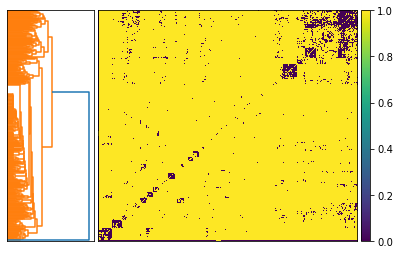

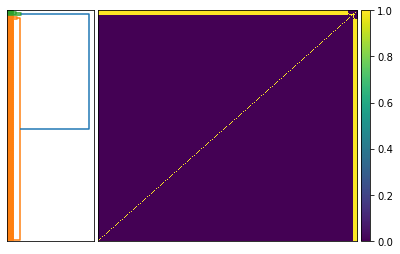

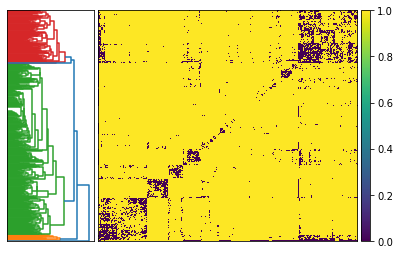

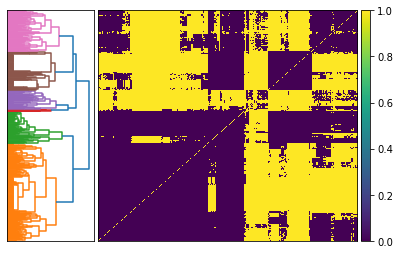

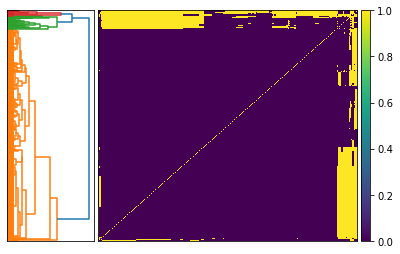

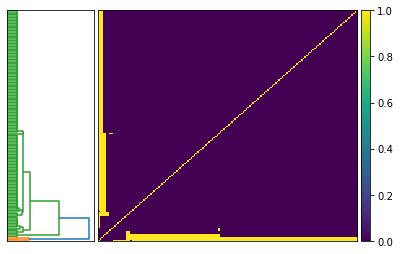

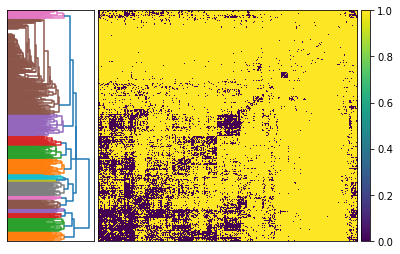

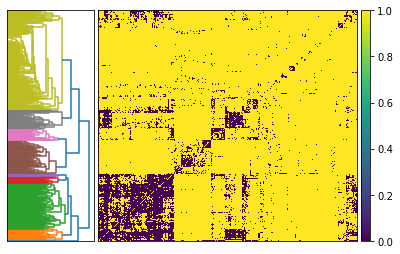

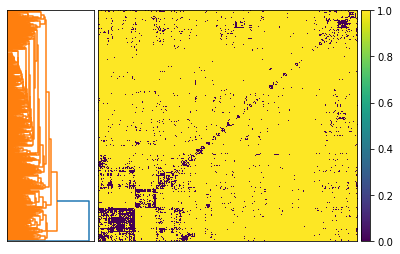

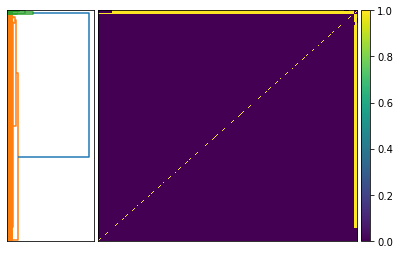

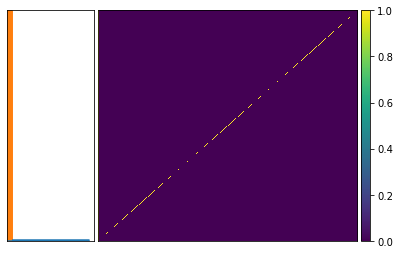

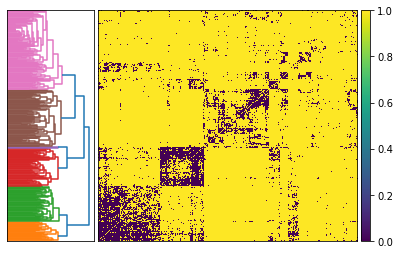

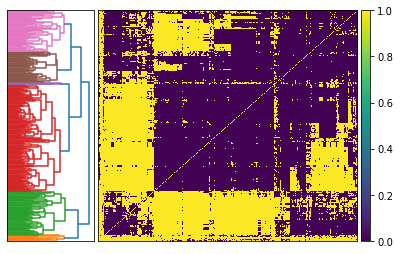

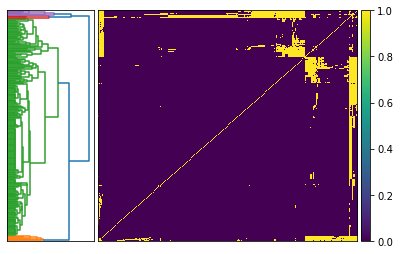

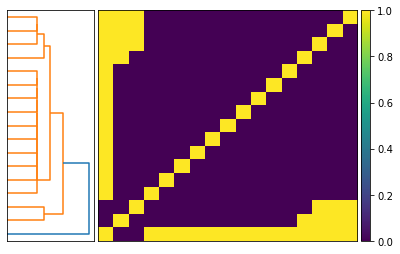

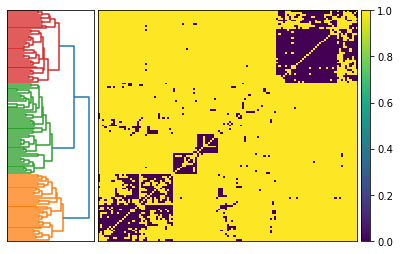

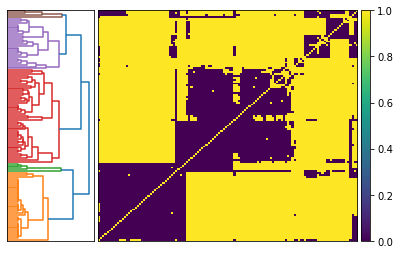

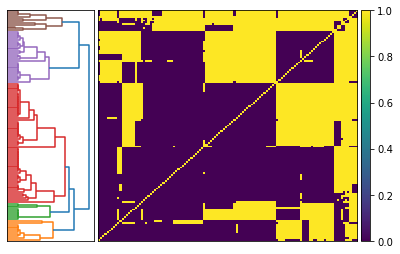

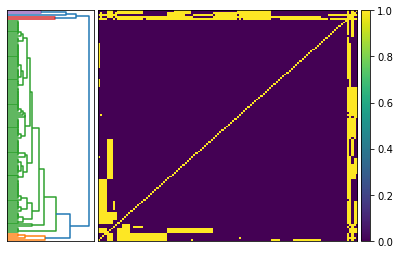

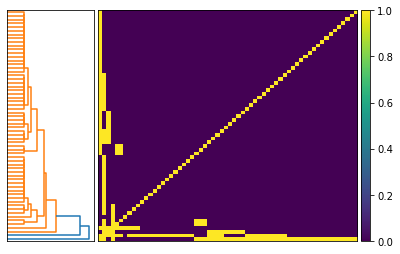

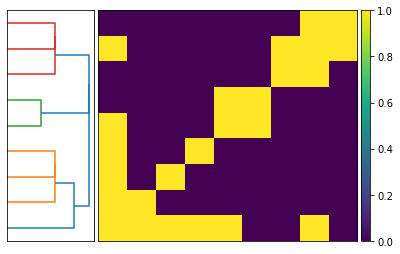

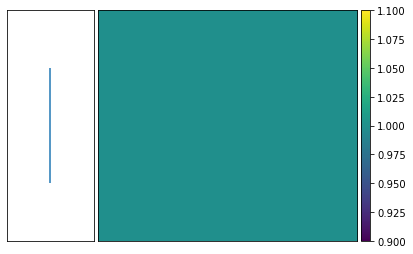

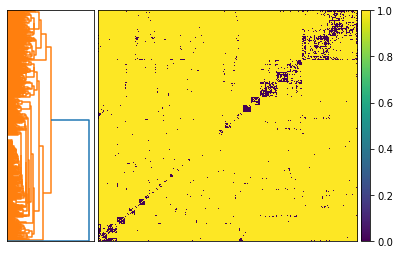

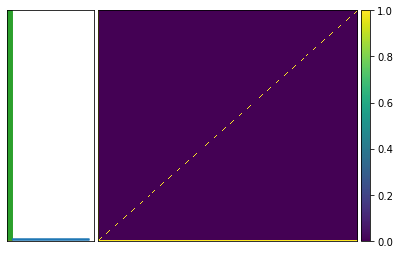

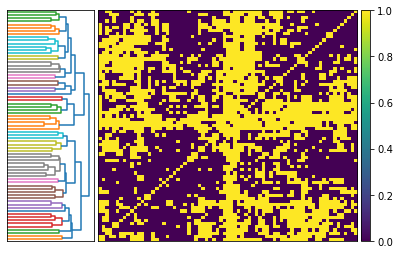

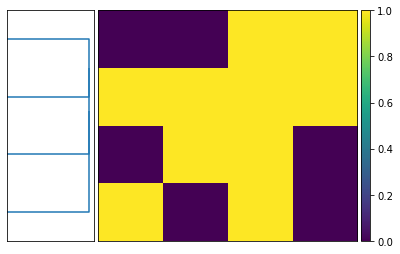

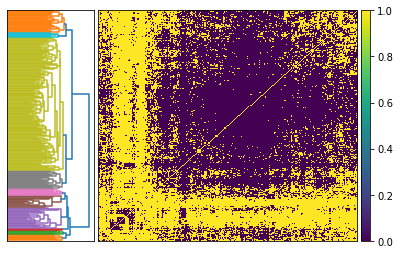

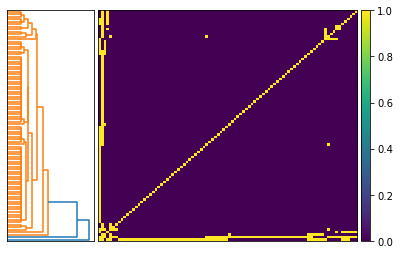

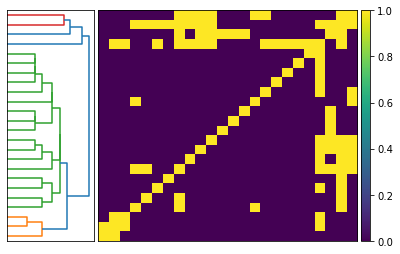

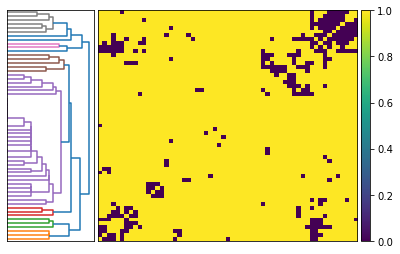

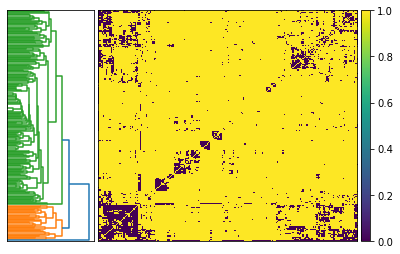

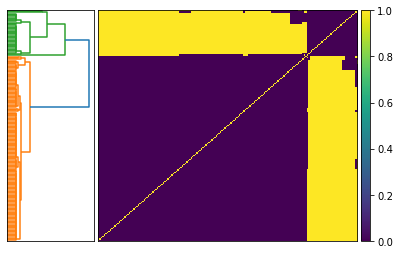

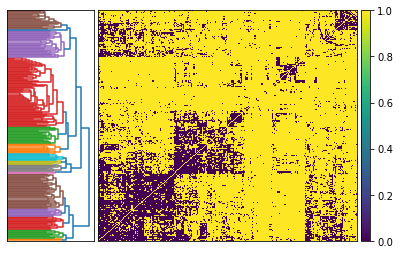

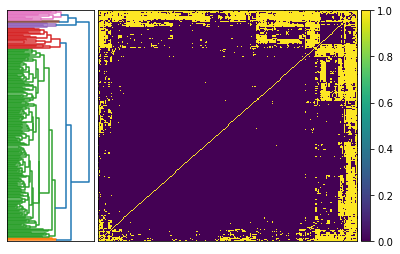

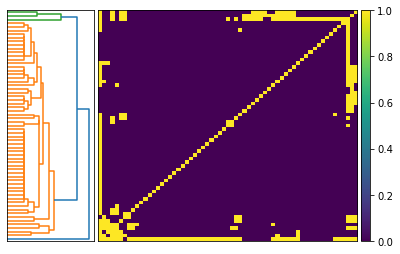

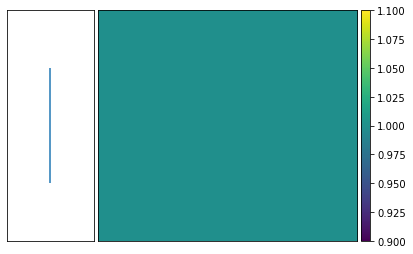

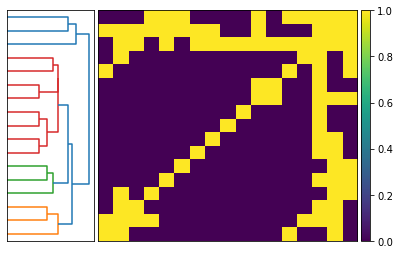

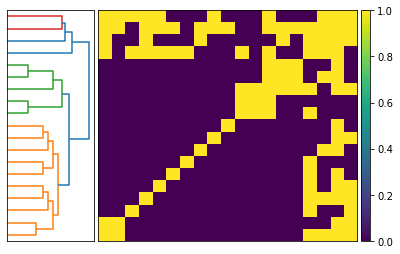

In [25]:
%time workerIds,partition,clusterGraph,clusterIds=assignWorkers(F,nbWorkers)
print(workerIds)

### What if we distantiated workers based on the whole graph (as if one unique community)

%time workerIds=F.vs[maxShortestPathNodesSelection(F,nbWorkers)]["name"]

## Plot

In [ ]:
for idx, cluster in enumerate(clusterGraph.vs):
    if cluster.index in clusterIds:
        cluster["size"]=50
    cluster["color"]=partition.subgraph(idx).vs[0]["color"]
    cluster["label"]="{}({})".format(idx,cluster["nb_workers"])
ig.plot(clusterGraph)

In [ ]:
for v in F.vs:
    if v["name"] in workerIds:
        v["size"]=25
        v["shape"]="triangle"
    else:
        v["size"]=1
        v["shape"]="circle"

In [ ]:
G=F.to_graph_tool(vertex_attributes={"color":"vector<float>","size":"int","shape":"string"},edge_attributes={"color":"vector<float>"})
gt.graph_draw(G, vertex_fill_color=G.vertex_properties["color"],vertex_shape=G.vertex_properties["shape"],vertex_size=G.vertex_properties["size"],edge_color=G.edge_properties["color"])

## Evaluate

In [ ]:
#Given a list of nodes, give distances between nodes
def calcDistBtwnNodes(graph,chosenNodeNames):
    return graph.shortest_paths_dijkstra(source=chosenNodeNames, target=chosenNodeNames)

In [ ]:
matPCC=calcDistBtwnNodes(F,workerIds)
PCCList=[]
for sublist in matPCC:
    PCCList.extend(sublist)
maxDist=max(PCCList)
PCCSelf=[]
PCCSameCluster=[]
PCCOtherCluster=[]

for i, dists in enumerate(matPCC):
    source=F.vs.find(workerIds[i])
    for j in range(i+1):
        target=F.vs.find(workerIds[j])
        #print(source,target)
        if source["name"]==target["name"]:
            PCCSelf.append(matPCC[i][j])
        elif source["cluster"]==target["cluster"]:
            PCCSameCluster.append(matPCC[i][j])
        else:
            PCCOtherCluster.append(matPCC[i][j])

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

data=[PCCSelf,PCCSameCluster,PCCOtherCluster]
colors=["grey","red","blue"]
labels=["self","same community","other community"]
# fixed bin size
bins = np.arange(0, 100, 1) # fixed bin size

plt.xlim([0, maxDist+1])
plt.yscale("log")
plt.hist(data, bins=bins, color=colors, label=labels, stacked=True)
plt.title('Shortest path lengths between workers')
plt.xlabel('Shortest path length')
plt.ylabel('Count of workers')

plt.show()

In [ ]:
from collections import Counter
print("Same",Counter(PCCSameCluster))
print("Other",Counter(PCCOtherCluster))

In [ ]:
#the greater the value, the better
print(sum(PCCList))

## Graph Metrics

### Max distance between nodes (graph diameter)

In [ ]:
print(F.diameter())

### Distances inter-nodes intra-clusters (cluster diameters)

In [ ]:
subgraphs=partition.subgraphs()
diameters=list([subgraph.diameter() for subgraph in subgraphs])
plt.plot(diameters)

In [ ]:
radii=list([subgraph.radius() for subgraph in subgraphs])
plt.plot(radii)

In [ ]:
eccentricities=list([subgraph.eccentricity() for subgraph in subgraphs])
print(eccentricities)

### Nodes per community

In [ ]:
from collections import Counter
nbClusters=len(Counter(F.vs["cluster"]))

In [ ]:
bins = np.arange(0, nbClusters+1, 1)
plt.hist(F.vs["cluster"], bins=bins)
plt.title('Number of nodes in communities')
plt.xlabel('Community')
plt.ylabel('Count of nodes')

plt.show()

### Workers per cluster

In [ ]:
data=[F.vs.find(worker)["cluster"] for worker in workerIds]
bins = np.arange(0, nbClusters+1, 1)
plt.hist(data, bins=bins)
plt.title('Number of workers in communities')
plt.xlabel('Community')
plt.ylabel('Count of workers')

plt.show()

### Cluster diameter based worker count

In [ ]:
diameters=[subgraph.diameter() for subgraph in partition.subgraphs()]

workers=[diameter//2+diameter%2 for diameter in diameters]
assignedWorkers=sum(workers)
print(assignedWorkers)

In [ ]:
import scipy
import pylab
import scipy.cluster.hierarchy as sch

# Generate features and distance matrix.
D = scipy.zeros([len(matPCC),len(matPCC)])
for i in range(40):
    for j in range(40):
        D[i,j] = matPCC[i][j]

# Compute and plot dendrogram.
fig = pylab.figure()
axdendro = fig.add_axes([0.09,0.1,0.2,0.8])
Y = sch.linkage(D, method='centroid')
Z = sch.dendrogram(Y, orientation='right')
axdendro.set_xticks([])
axdendro.set_yticks([])

# Plot distance matrix.
axmatrix = fig.add_axes([0.3,0.1,0.6,0.8])
index = Z['leaves']
D = D[index,:]
D = D[:,index]
im = axmatrix.matshow(D, aspect='auto', origin='lower')
axmatrix.set_xticks([])
axmatrix.set_yticks([])

# Plot colorbar.
axcolor = fig.add_axes([0.91,0.1,0.02,0.8])
pylab.colorbar(im, cax=axcolor)

# Display and save figure.
fig.show()
fig.savefig('dendrogram.png')

#Dendrogram and distance matrix